This notebook is going to walk through how to arrive at the results that we reported in our manuscript. This is not how we originally calculated them, but a cleaned-up, condensed, and documented version.

In [1]:
import sys
sys.path.append("..")

In [173]:
import copy
from io import StringIO # for sketchy stuff
from nlgeval import NLGEval # for running baseline eval metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for reading CSV
from scipy.special import logsumexp
from scipy.stats import pearsonr, spearmanr, kendalltau

import caption_featurizers
import color_featurizers
from experiment import FeatureHandler
from models import LiteralListener, CaptionEncoder
from models import LiteralSpeakerScorer, CaptionGenerator
from monroe_data import MonroeData, MonroeDataEntry, Color


%matplotlib inline

# 0. Notes on this Dataset

Our collected data is numbered 0-9 (inclusive)
    Descriptive data is even
    Ambiguous data is odd
Monroe dev data used is numbered 10+
    All monroe data is descriptive



# 1. Load CSV

In [3]:
%%time
# We set single_speaker to false to not do any Monroe-specific preprocessing
all_data = MonroeData("../data/csv/clean_data.csv", single_speaker=False)
# for _ in all_data.read_data(): pass

CPU times: user 44.2 ms, sys: 15.8 ms, total: 60 ms
Wall time: 83 ms


# 2. Separate into Descriptive and Ambiguous

In [4]:
desc_all = all_data.data[all_data.data['quality'] == "descriptive"]
ambi_all = all_data.data[all_data.data['quality'] == "ambiguous"]

# 3. Filter Descriptive Utterances:
Where there are at least 3 contexts with same contextNum and context id keep all of them where at least 2/3 of the listeners choose the target. We don't bother to sort out which ones have 3 contexts (newman) from those that have 1 (monroe), because the listeners are successful in the monroe case, so they are correct 100% of the time

In [5]:
desc_grouped = desc_all.groupby(["contextId", "contextNum"])
desc_approved = desc_grouped.filter(lambda x: (x['clickStatus'] == 'target').mean() >= 2/3)

In [421]:
len(desc_approved)

4814

# 4. Filter Ambiguous Utterances:
Remove all the contexts that do not overlap with their context's descriptive utterances. Make sure all of the captions are normalized before comparing

In [8]:
def normalize(caption):
    """Makes captin text more uniform - lowercases, removes unecessary white space"""
    return caption.lower().strip().replace('"', "")

# TODO: fix the global variable here
def ambi_filter(contextIds, captions):
    """ filter out ambiguous captions that overlap with descriptive ones"""
    # all of the contextIds and captions are identical, so just take the first one.
    contextId = contextIds.iloc[0]
    caption = captions.iloc[0]
    desc_captions = desc_approved[desc_approved["contextId"] == contextId]["contents"]
    desc_captions = [normalize(desc_caption) for desc_caption in desc_captions]
    return normalize(caption) not in desc_captions

In [9]:
ambi_grouped = ambi_all.groupby(["contextId", "contextNum"])
ambi_approved = ambi_grouped.filter(lambda x: ambi_filter(x['contextId'], x['contents'])) # automatically drops rows with nans

# 5. Separate into flipped and unflipped

Unlipped conditions have the "original" target while flipped conditions have a different target. The flipped descriptive captions will be the misleading captions for the unflipped ones and the unflipped descriptive captions will be the misleading captions for the flipped ones.

Unflipped context ids end in .0, flipped ones end in .1

In [12]:
desc_unflipped_all = desc_approved[desc_approved['contextId'].str.contains(".0", regex=False)]
desc_flipped_all = desc_approved[desc_approved['contextId'].str.contains(".1", regex=False)]

ambi_unflipped_all = ambi_approved[ambi_approved['contextId'].str.contains(".0", regex=False)]
ambi_flipped_all = ambi_approved[ambi_approved['contextId'].str.contains(".1", regex=False)]

# 6. Prepare for metrics

For the NLG and Listener metrics, we don't really care what the 3 listeners' responses were so let's just choose the first entry to represent all of them.

In [13]:
desc_unflipped = desc_unflipped_all.groupby(['contextId', 'contextNum']).first().reset_index()
desc_flipped = desc_flipped_all.groupby(['contextId', 'contextNum']).first().reset_index()

ambi_unflipped = ambi_unflipped_all.groupby(['contextId', 'contextNum']).first().reset_index()
ambi_flipped = ambi_flipped_all.groupby(['contextId', 'contextNum']).first().reset_index()

In [420]:
len(desc_unflipped)

971

With these metrics, it is going to be easier to work with lists of captions / color-caption contexts than with pandas dataframes, so let's convert the dataframes to context lists

In [14]:
def df_to_ctxs(df):
    """Convert a pandas dataframe into a list of MonroeDataEntries"""
    # This is going to be a bit unconventional, but we're just going
    # to instantiate these MonroeData objects with no data, place the
    # passed df into where the data should go, and create MonroeEntries
    # from that df
    md = MonroeData(StringIO(",".join(df.columns)), # pd.read_csv needs columns
                    single_speaker=False)           # don't do any fancy filtering
    md.data = df
    for _ in md.read_data(): pass
    return md.entries

In [185]:
%%time
desc_unflipped_ctxs = df_to_ctxs(desc_unflipped)
desc_flipped_ctxs = df_to_ctxs(desc_flipped)

ambi_unflipped_ctxs = df_to_ctxs(ambi_unflipped)
ambi_flipped_ctxs = df_to_ctxs(ambi_flipped)

CPU times: user 12.8 s, sys: 723 ms, total: 13.6 s
Wall time: 13.6 s


# 7. N-Gram Overlap Metrics

Extract descriptive, ambiguous, and misleading captions along with their references for the flipped and unflipped groups. These are used for calculating all of our n-gram overlap metrics.

We need two lists:
References
Candidates

In [187]:
def group_contexts(df, ctx_list):
    """Turn list of contexts into list of lists of contexts with the same colors"""
    
    # assumes ctx_list is in the same order as df rows
    
    # count how many of each contextId we have
    df_counts = df.groupby('contextId')['contextId'].transform("count")
    grouped_ctx_list = []

    # reshape ctx_list into list of lists. Outer list will have one list for each
    # contextId, and each sublist will hold all of the contexts.
    count = df_counts[0]
    i = count
    total = i
    group = []
    for ctx in ctx_list:
        if count == 0:
            count = df_counts[i]
            i += count
            total += count
            grouped_ctx_list.append(group)
            group = []

        group.append(ctx)
        count -= 1
    
    grouped_ctx_list.append(group)
    return grouped_ctx_list

In [188]:
desc_unflipped_ctxs_grouped = group_contexts(desc_unflipped, desc_unflipped_ctxs)
desc_flipped_ctxs_grouped = group_contexts(desc_flipped, desc_flipped_ctxs)

ambi_unflipped_ctxs_grouped = group_contexts(ambi_unflipped, ambi_unflipped_ctxs)
ambi_flipped_ctxs_grouped = group_contexts(ambi_flipped, ambi_flipped_ctxs)

In [275]:
def pad_ambi_groups(desc_df, ambi_df, ambi_groups):
    """Add empty lists int ambi_groups for contexts not used"""
    desc_ids = desc_df["contextId"].unique()
    ambi_ids = ambi_df["contextId"].unique()
    num_missed_ids = 0
    groups = []
    for i, contextId in enumerate(desc_ids):
        if contextId in ambi_ids:
            groups.append(ambi_groups[i - num_missed_ids])
        else:
            groups.append([])
            num_missed_ids += 1
    return groups

In [279]:
ambi_unflipped_ctxs_grouped = pad_ambi_groups(desc_unflipped, ambi_unflipped, ambi_unflipped_ctxs_grouped)
ambi_flipped_ctxs_grouped = pad_ambi_groups(desc_flipped, ambi_flipped, ambi_flipped_ctxs_grouped)

In [66]:
def extract_captions(ctx_list):
    """Helper function to convert list of contexts to list of string captions"""
    return [normalize(ctx.caption) for ctx in ctx_list]

def extract_references(reference_ctxs, candidate_ctxs=None):
    """Uses reference_ctxs to create reference list so each candidate in candiate_ctxs"""
    references = []
    if candidate_ctxs is None:
        # generate references in leave-one out style
        for i in range(len(reference_ctxs)):
            if len(reference_ctxs[i]) == 1:
                # if there's only one caption, let it be its own reference
                references.append(extract_captions(reference_ctxs[i]))
                continue
            for j in range(len(reference_ctxs[i])):
                refs = reference_ctxs[i][:j] + reference_ctxs[i][j+1:]
                references.append(extract_captions(refs))

    else:
        # generate references using all references
        for i in range(len(candidate_ctxs)): # same as len(reference_ctxs)
            
            for j in range(len(candidate_ctxs[i])):
                references.append(extract_captions(reference_ctxs[i]))

    return references           

In [285]:
# unflipped contexts - descriptive and ambiguous
desc_unflipped_captions = extract_captions(desc_unflipped_ctxs)
desc_unflipped_references = extract_references(desc_unflipped_ctxs_grouped)

ambi_unflipped_captions = extract_captions(ambi_unflipped_ctxs)
ambi_unflipped_references = extract_references(desc_unflipped_ctxs_grouped, ambi_unflipped_ctxs_grouped)

In [287]:
len(ambi_unflipped_references) + len(ambi_flipped_references)

1343

In [268]:
len(ambi_unflipped_ctxs_grouped)

176

In [288]:
# now do the same for the flipped contexts - descriptive and ambiguous
desc_flipped_captions = extract_captions(desc_flipped_ctxs)
desc_flipped_references = extract_references(desc_flipped_ctxs_grouped)

ambi_flipped_captions = extract_captions(ambi_flipped_ctxs)
ambi_flipped_references = extract_references(desc_flipped_ctxs_grouped, ambi_flipped_ctxs_grouped)

In [404]:
# def filter_ambiguous(reference_ctxs, candidate_ctxs):
#     """remove captions in reference set (in far condition)"""
#     new_references = []
#     new_contexts = []
#     new_captions = []
    
#     for i in range(len(candidate_ctxs)): # same as len(reference_ctxs)
            
#             for j in range(len(candidate_ctxs[i])):
#                 if (not candidate_ctxs[i][j].outcome
#                     or normalize(candidate_ctxs[i][j].caption) in extract_captions(reference_ctxs[i])):
#                     continue
                
#                 new_references.append(extract_captions(reference_ctxs[i]))
#                 new_contexts.append(candidate_ctxs[i][j])
#                 new_captions.append(normalize(candidate_ctxs[i][j].caption))

#     return new_contexts, new_references, new_captions

def filter_misleading(reference_ctxs, candidate_ctxs):
    """remove captions in reference set (in far condition)"""
    new_references = []
    new_contexts = []
    new_captions = []
    
    for i in range(len(candidate_ctxs)): # same as len(reference_ctxs)
            context_group = []
            for j in range(len(candidate_ctxs[i])):
                if (candidate_ctxs[i][j].condition == "far" and
                    normalize(candidate_ctxs[i][j].caption) in extract_captions(reference_ctxs[i])):
                    continue
                
                new_references.append(extract_captions(reference_ctxs[i]))
                context_group.append(candidate_ctxs[i][j])
                new_captions.append(normalize(candidate_ctxs[i][j].caption))
            new_contexts.append(context_group)

    return new_contexts, new_references, new_captions

def swap_colors(desc_ctxs, misl_ctxs):
    """Swaps colors from descriptive contexts to misleading contexts so misleading contexts are actually misleading"""
    new_misl_ctxs = copy.deepcopy(misl_ctxs)
    new_misl_ctxs_flat = []
    for i in range(len(misl_ctxs)): # should be the same as len(misl_ctxs)
        for j in range(len(misl_ctxs[i])):
            new_misl_ctxs[i][j].colors = copy.copy(desc_ctxs[i][0].colors)
            new_misl_ctxs_flat.append(new_misl_ctxs[i][j])
    return new_misl_ctxs_flat

In [289]:
# We have to do some filtering based on references for misleading candidates, so we treat them separately
# Filter the misleading contexts so that the listener metrics can use them too
misl_unflipped_ctxs_grouped, misl_unflipped_references, misl_unflipped_captions = filter_misleading(desc_unflipped_ctxs_grouped,
                                                                                            desc_flipped_ctxs_grouped)
misl_flipped_ctxs_grouped, misl_flipped_references, misl_flipped_captions = filter_misleading(desc_flipped_ctxs_grouped,
                                                                                      desc_unflipped_ctxs_grouped)


In [405]:
# copy colors from descriptive to misleading
misl_unflipped_ctxs = swap_colors(desc_unflipped_ctxs_grouped, misl_unflipped_ctxs_grouped)
misl_flipped_ctxs = swap_colors(desc_flipped_ctxs_grouped, misl_flipped_ctxs_grouped)

Now we can run the nlg metrics to calculate our scores!

In [22]:
class NgramMetrics:
    """
    Wrapper function for stuff.
    """
    def __init__(self):
        # loads metrics without extra (slow) models
        self.nlgeval_metrics = NLGEval(no_overlap=False, no_glove=True, no_skipthoughts=True)

    def get_overlap_scores(self, refs, hyps):
        """Calculates n-gram scores given list of lists of references and list of candidates"""
        refs = {idx: lines for (idx, lines) in enumerate(refs)}
        hyps = {idx: [line] for (idx, line) in enumerate(hyps)}
        ret_scores = {}
        for scorer, method in self.nlgeval_metrics.scorers:
            score, scores = scorer.compute_score(refs, hyps)
            if isinstance(method, list):
                for sc, scs, m in zip(score, scores, method):
                    ret_scores[m] = (sc, scs)
            else:
                ret_scores[method] = (score, scores)
        return ret_scores

# instantiate metric class
ngram_metrics = NgramMetrics()

In [291]:
np.mean([
    np.mean([len(ref) for ref in desc_unflipped_references + desc_flipped_references]),
    np.mean([len(ref) for ref in ambi_unflipped_references + ambi_flipped_references]),
    np.mean([len(ref) for ref in misl_unflipped_references + misl_flipped_references])
])

5.206221668863967

In [230]:
ambi_unflipped_references_reordered = [x[1] for x in sorted(zip(ambi_unflipped.sort_values(by='contextId').contextId, ambi_unflipped_references),
       key = lambda x: float(x[0][2:]))]

In [233]:
sorted(zip(ambi_unflipped.sort_values(by='contextId').contextId, ambi_unflipped_references),
       key = lambda x: float(x[0][2:]))

[('ci0.0',
  ['bright pink',
   'light pink',
   'bright pink',
   'bright purple',
   'brightest color',
   'lightest shade']),
 ('ci0.0',
  ['bright pink',
   'light pink',
   'bright pink',
   'bright purple',
   'brightest color',
   'lightest shade']),
 ('ci0.0',
  ['bright pink',
   'light pink',
   'bright pink',
   'bright purple',
   'brightest color',
   'lightest shade']),
 ('ci0.0',
  ['bright pink',
   'light pink',
   'bright pink',
   'bright purple',
   'brightest color',
   'lightest shade']),
 ('ci1.0',
  ['dim gray',
   'neutral gray',
   'lighter gray',
   'grey. looks less purple than the other one.',
   'grey grey']),
 ('ci1.0',
  ['dim gray',
   'neutral gray',
   'lighter gray',
   'grey. looks less purple than the other one.',
   'grey grey']),
 ('ci1.0',
  ['dim gray',
   'neutral gray',
   'lighter gray',
   'grey. looks less purple than the other one.',
   'grey grey']),
 ('ci1.0',
  ['dim gray',
   'neutral gray',
   'lighter gray',
   'grey. looks less pur

In [245]:
list(zip(ambi_unflipped.sort_values(by='contextId').contextId, ambi_unflipped_references))

[('ci0.0',
  ['bright pink',
   'light pink',
   'bright pink',
   'bright purple',
   'brightest color',
   'lightest shade']),
 ('ci0.0',
  ['bright pink',
   'light pink',
   'bright pink',
   'bright purple',
   'brightest color',
   'lightest shade']),
 ('ci0.0',
  ['bright pink',
   'light pink',
   'bright pink',
   'bright purple',
   'brightest color',
   'lightest shade']),
 ('ci0.0',
  ['bright pink',
   'light pink',
   'bright pink',
   'bright purple',
   'brightest color',
   'lightest shade']),
 ('ci1.0',
  ['dim gray',
   'neutral gray',
   'lighter gray',
   'grey. looks less purple than the other one.',
   'grey grey']),
 ('ci1.0',
  ['dim gray',
   'neutral gray',
   'lighter gray',
   'grey. looks less purple than the other one.',
   'grey grey']),
 ('ci1.0',
  ['dim gray',
   'neutral gray',
   'lighter gray',
   'grey. looks less purple than the other one.',
   'grey grey']),
 ('ci1.0',
  ['dim gray',
   'neutral gray',
   'lighter gray',
   'grey. looks less pur

In [302]:
desc_ngram_scores = ngram_metrics.get_overlap_scores(desc_unflipped_references + desc_flipped_references,
                                                     desc_unflipped_captions + desc_flipped_captions)
ambi_ngram_scores = ngram_metrics.get_overlap_scores(ambi_unflipped_references + ambi_flipped_references,
                                                     ambi_unflipped_captions + ambi_flipped_captions)
misl_ngram_scores = ngram_metrics.get_overlap_scores(misl_unflipped_references + misl_flipped_references,
                                                     misl_unflipped_captions + misl_flipped_captions)

Now we can visualize stuff with the plots and check our correlations

In [30]:
def plot_score_dists_for_metric(scores, metric):
    plot_data = [score[metric][1] for score in scores]
    
    # let's also get the correlation coefficients
    # domain is [1, 1, 1, ...], [2, 2, 2, ...], [3, 3, 3, 3, ...]
    # we could do fancy things with np.flatten(), but that doesn't work for lists with varying dimensions
    correlation_support = []
    for i, d in enumerate(plot_data):
        correlation_support.extend([i+1] * len(d))
        
    plot_data_flat = []
    for d in plot_data:
        plot_data_flat.extend(d)

    print(pearsonr(correlation_support, plot_data_flat))
    print(spearmanr(correlation_support, plot_data_flat))
    print(kendalltau(correlation_support, plot_data_flat))
    
    # now plot the violin plots
    plt.violinplot(plot_data, showmeans=True)
    plt.xticks([1, 2, 3], ["Descriptive", "Ambiguous", "Misleading"])
    plt.title("{} scores of captions".format(metric))
    plt.show()
    
def plot_score_dists(*scores, metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr']):
    for metric in metrics:
        plot_score_dists_for_metric(scores, metric)
        

(-0.3628210988999967, 1.8645390253482644e-160)
SpearmanrResult(correlation=-0.3494045990442967, pvalue=3.582805276242994e-148)
KendalltauResult(correlation=-0.29031567148602705, pvalue=1.5732871070854286e-143)


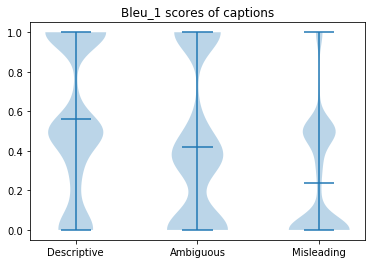

(-0.441438926285, 2.772001603208712e-245)
SpearmanrResult(correlation=-0.43851287378081355, pvalue=1.0582869970875142e-241)
KendalltauResult(correlation=-0.3783911681463812, pvalue=8.209748712908123e-231)


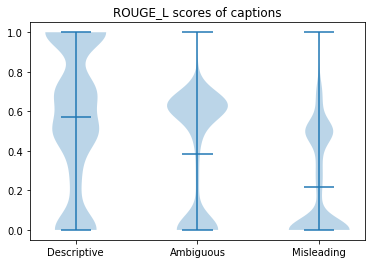

(-0.48222022809176895, 4.968323145060464e-299)
SpearmanrResult(correlation=-0.47927839309905035, pvalue=6.645360205288503e-295)
KendalltauResult(correlation=-0.4039142564215139, pvalue=1.529353521063455e-277)


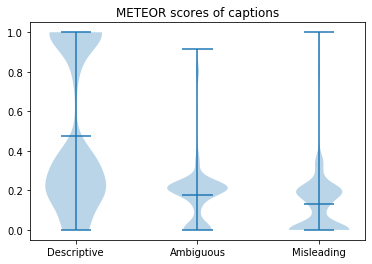

(-0.3983199580160847, 6.2803522712535885e-196)
SpearmanrResult(correlation=-0.4132355589958685, pvalue=3.449125025206676e-212)
KendalltauResult(correlation=-0.3373172347922543, pvalue=1.0615598096345676e-197)


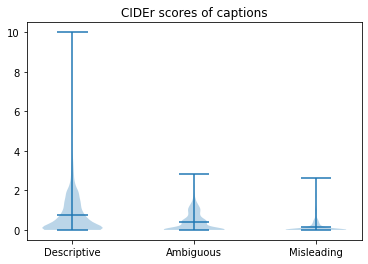

In [303]:
plot_score_dists(desc_ngram_scores, ambi_ngram_scores, misl_ngram_scores)

CIDEr is the only one that's different here because we use all of the captions in that condition (descriptive, ambiguous, misleading) for calculating the IDF. This difference is small: 0.398 in the combined condition, 0.403 in the separate flipped/unflipped condition

# Listener Evaluation
Use the models

In [160]:
# TODO: move this to python file - it should not exist in this notebook
class ListenerMetrics:
    
    def __init__(self):
        self.train_data = train_data#MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
        
        self.caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)
        self.color_phi_ll = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "rgb", normalized=True) # NOTE: RGB
        self.color_phi_pl = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "hsv", normalized=True) # NOTE: HSV

        
        # placeholder feature handler to load vocab (this is ugly) TODO
        fh = FeatureHandler(self.train_data, self.train_data, self.caption_phi, self.color_phi_ll)
        self.model_ll = LiteralListener(CaptionEncoder)
        self.model_ll.init_model(
                    embed_dim=100,
                    hidden_dim=100,
                    vocab_size=fh.caption_featurizer.caption_indexer.size,
                    color_dim=54)
        
        self.model_ll.load_model("../model/literal_listener_5epoch_endings_tkn.params")
        
        self.model_pl = LiteralSpeakerScorer(CaptionGenerator)
        self.model_pl.init_model(
                    color_in_dim=54,
                    color_dim=100,
                    vocab_size=fh.caption_featurizer.caption_indexer.size,
                    embed_dim=100,
                    speaker_hidden_dim=100)
        
        self.model_pl.load_model("../model/literal_speaker_30epochGLOVE.params")

    def get_lit_listener_scores(self, eval_contexts):
        """Queries Literal Listener model for each target color given caption."""
        # assumes everything else is loaded up and ready...
        feature_handler = FeatureHandler(self.train_data,
                                         eval_contexts,
                                         self.caption_phi,
                                         self.color_phi_ll,
                                         randomized_colors=True)
        X_assess = feature_handler.test_features()
        y_assess = feature_handler.test_targets()

        preds = self.model_ll.predict(X_assess)
        scores = preds[np.arange(len(preds)), y_assess]
        return scores
    
    
    def speaker_target(self, data_entry):
        """Gets tokens speaker should produce - used for training speaker model."""
        _, caption_ids = self.caption_phi.to_string_features(data_entry.caption) # this probably works...
        target = caption_ids[1:]
        return target
    
    def speaker_predictions_to_scores(self, results, targets):
        """Converts speaker's predictions over tokens to a score for each color."""
        all_scores = []
        target_lens = np.array([len(target) for target in targets])
        for i, predictions in enumerate(results):
            scores = [0, 0, 0]
            for j, prediction in enumerate(predictions):
                scores[j] = np.sum(prediction[np.arange(target_lens[i]), targets[i]].numpy()) # end tokens are already cut off

            all_scores.append(scores)

        # now we can softmax these probabilities in log space
        all_scores = np.array(all_scores)
        all_scores_dist = (all_scores.T - logsumexp(all_scores, axis=1)).T
        # the target is at index 0
        return all_scores_dist[:, 0]

    def get_prag_listener_scores(self, eval_contexts):
        """Queries Pragmatic Listener model for scores for each color given caption"""
        # assumes everything else is loaded up and ready...
        feature_handler = FeatureHandler(self.train_data,
                                         eval_contexts,
                                         self.caption_phi,
                                         self.color_phi_pl,
                                         randomized_colors=False,
                                         target_fn=self.speaker_target)
        X_assess = feature_handler.test_features()
        y_assess = feature_handler.test_targets()

        preds = self.model_pl.predict(X_assess)
        scores = self.speaker_predictions_to_scores(preds, y_assess)
        return scores
    
    def get_listener_scores(self, eval_contexts):
        """Run all listener eval metrics and return scores in dictionaries"""
        
        ll_scores = np.exp(self.get_lit_listener_scores(eval_contexts))
        pl_scores = np.exp(self.get_prag_listener_scores(eval_contexts))
        results = {
            "Literal Listener": (np.mean(ll_scores), ll_scores),
            "Pragmatic Listener": (np.mean(pl_scores), pl_scores)
        }
        return results


In [161]:
listener_metrics = ListenerMetrics()

In [406]:
%%time
# now run the evaluation
# desc_listener_scores = listener_metrics.get_listener_scores(desc_unflipped_ctxs + desc_flipped_ctxs)
# ambi_listener_scores = listener_metrics.get_listener_scores(ambi_unflipped_ctxs + ambi_flipped_ctxs)
misl_listener_scores = listener_metrics.get_listener_scores(misl_unflipped_ctxs + misl_flipped_ctxs)

CPU times: user 26.9 s, sys: 196 ms, total: 27.1 s
Wall time: 16.9 s


In [376]:
ambi_listener_scores['Pragmatic Listener'][0]

0.38821253

In [202]:
len(misl_listener_scores["Literal Listener"][1])

1909

(-0.5808064191722528, 0.0)
SpearmanrResult(correlation=-0.6134841552848016, pvalue=0.0)
KendalltauResult(correlation=-0.4862705243417515, pvalue=0.0)


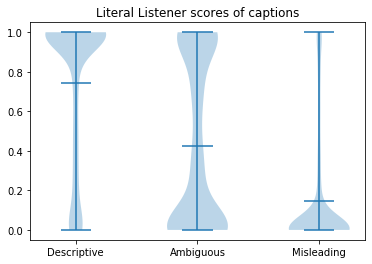

(-0.5534376118855695, 0.0)
SpearmanrResult(correlation=-0.555467028649594, pvalue=0.0)
KendalltauResult(correlation=-0.44328846106201203, pvalue=0.0)


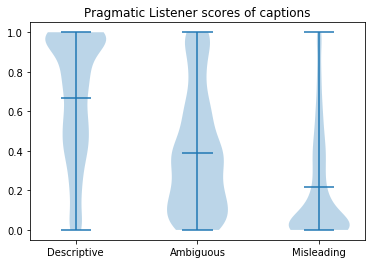

In [327]:
plot_score_dists(desc_listener_scores, ambi_listener_scores, misl_listener_scores, metrics=["Literal Listener", "Pragmatic Listener"])

In [366]:
len(bad_pl_scores_flipped)

659

In [350]:
#good_listener_scores_unflipped = np.exp(good_listener_scores_unflipped)

In [370]:
ambi_listener_scores_pl = np.array([x[1] for x in sorted(zip(ambi_unflipped.sort_values(by='contextId').contextId, _listener_scores['Pragmatic Listener'][1][:971]),
       key = lambda x: float(x[0][2:]))])



In [371]:
np.allclose(ambi_listener_scores_pl_flipped, np.exp(bad_pl_scores_flipped))

True

In [384]:
misl_unflipped_ids = []
num_missed_ids = 0
for i, cid in enumerate(desc_flipped.contextId):
    if normalize(desc_flipped.iloc[i].contents) == misl_unflipped_captions[i - num_missed_ids]:
        misl_unflipped_ids.append(cid)
    else:
        num_missed_ids += 1

In [387]:
misl_flipped_ids = []
num_missed_ids = 0
for i, cid in enumerate(desc_unflipped.contextId):
    if normalize(desc_unflipped.iloc[i].contents) == misl_flipped_captions[i - num_missed_ids]:
        misl_flipped_ids.append(cid)
    else:
        num_missed_ids += 1

In [389]:
len(misl_flipped_ids)

970

In [ ]:
desc_flipped.sort_values(by='contextId').contextId

In [391]:
np.where(
    np.array([x[1] for x in sorted(zip(misl_flipped_ids, misl_listener_scores['Pragmatic Listener'][1][939:]),
                                   key = lambda x: float(x[0][2:]))]) !=
    np.exp(np.array([-3.65301466e+00, -2.19677496e+00, -3.65301466e+00, -1.13348579e+00,
       -3.13424301e+00, -2.04433250e+00, -4.00666428e+00,  0.00000000e+00,
       -6.60716057e-01, -7.24792480e-05, -2.29696131e+00, -1.06687889e+01,
       -6.22218847e+00, -6.01662970e+00, -8.00376987e+00, -6.91889191e+00,
       -3.94969940e+00, -6.01662970e+00, -1.58324471e+01, -8.50249481e+00,
       -2.59140396e+00, -2.18631172e+00, -5.52100515e+00, -4.40820217e-01,
       -3.50349903e-01, -4.40820217e-01, -4.40820217e-01, -5.85802794e-01,
       -4.40820217e-01, -2.83083200e+00, -1.24202204e+00, -1.24202204e+00,
       -2.70397282e+00, -1.24202204e+00, -2.83083200e+00, -2.83083200e+00,
       -2.66477966e+00, -5.16273308e+00, -3.12895966e+00, -5.41581421e+01,
       -1.64802933e+00, -2.55911064e+00, -3.15942001e+00, -9.30597305e-01,
       -2.27578497e+00, -2.49810123e+00, -9.30597305e-01, -1.51885605e+00,
       -1.74606514e+00, -9.75084019e+00, -9.75084019e+00, -9.75084019e+00,
       -6.05011463e+00, -9.75084019e+00, -7.83648062e+00, -9.75084019e+00,
       -1.66669464e+00, -3.43823862e+00, -1.53861427e+00, -4.02085924e+00,
       -1.31727791e+00, -1.56819248e+00, -7.56979704e-01, -1.04772615e+00,
       -2.15398788e-01, -1.04772615e+00, -2.88546777e+00, -7.51013756e-01,
       -9.18530464e+00, -4.40935469e+00, -9.17218208e+00, -9.18530464e+00,
       -7.78720570e+00, -8.64019203e+00, -2.16952324e+00, -1.81996727e+00,
       -1.72753811e+00, -2.19903421e+00, -1.84666824e+00, -3.03368568e-01,
       -2.19903421e+00, -1.87217140e+00, -2.19903421e+00, -1.67551422e+00,
       -4.84997177e+00, -4.84997177e+00, -4.66421413e+00, -4.66421413e+00,
       -5.50043726e+00, -9.26182938e+00, -4.66421413e+00, -1.96269941e+00,
       -1.25595140e+00, -1.96269941e+00, -1.14833784e+00, -2.45584726e+00,
       -9.45180893e-01, -8.87679577e-01, -9.33151245e-01, -8.85365486e-01,
       -6.51681900e-01, -5.44263363e-01, -2.47171640e+00, -7.89639473e-01,
       -7.89639473e-01, -6.45895767e+00, -5.65222454e+00, -6.45895767e+00,
       -1.66392612e+00, -5.37876558e+00, -1.83873177e+00, -5.65222454e+00,
       -1.58152223e+00, -1.58152223e+00, -9.51730251e-01, -2.35208416e+00,
       -1.24812317e+00, -2.57021809e+00, -3.24249268e-03, -2.24093437e-01,
       -2.33654499e-01, -4.50305939e-02, -1.43288040e+01, -2.24093437e-01,
       -1.74923420e-01, -4.32664633e+00, -4.32664633e+00, -4.40429163e+00,
       -4.32664633e+00, -4.40429163e+00, -8.81058693e+00, -4.40429163e+00,
       -1.09827137e+00, -5.92632294e+00, -4.13274574e+00, -2.12229538e+00,
       -1.16873264e+00, -1.16257000e+00, -1.11375237e+00, -5.23183823e-01,
       -9.36617255e-01, -2.44900131e+00, -5.02254963e+00, -6.34962940e+00,
       -8.14655590e+00, -3.20130348e+00, -3.31174850e+00, -8.14655590e+00,
       -8.14655590e+00, -8.06970596e-01, -2.70656586e-01, -9.48703289e-01,
       -1.51875877e+00, -1.62914276e-01, -9.03721809e-01, -5.67484856e-01,
       -3.03368568e-01, -2.55455256e-01, -2.55455256e-01, -3.15761566e-01,
       -2.07509995e-01, -1.37615204e-03, -2.60048985e+00, -4.50723457e+00,
       -4.38942909e-01, -3.49658489e+00, -4.39002609e+00, -1.37690926e+00,
       -3.80891585e+00, -8.49812746e-01, -2.74646568e+00, -1.90040636e+00,
       -3.33185434e+00, -1.29912567e+00, -9.01103020e-01, -7.98422813e-01,
       -1.29889297e+00, -9.84931946e-01, -3.52010193e+01, -8.77880955e+00,
       -6.62256851e+01, -6.62256851e+01, -8.88528252e+00, -2.89133873e+01,
       -6.62256851e+01, -6.62256851e+01, -1.66539478e+00, -1.87093544e+00,
       -4.10642052e+00, -5.10781097e+00, -1.88871613e+01, -7.40560532e+00,
       -2.44211674e+00, -2.98068047e+00, -2.02388573e+00, -3.59482765e-02,
       -1.70839548e+00, -4.65646744e+00, -1.79219971e+01, -1.58645287e+01,
       -1.24750385e+01, -7.61901093e+00, -2.34670639e+00, -7.10399389e+00,
       -7.61901093e+00, -1.38601685e+00, -8.38285446e-01, -9.10250664e-01,
       -1.99661255e-02, -9.62943792e-01, -1.52587891e-05, -1.11732769e+00,
       -7.45287895e-01, -3.85187149e+00, -2.78487372e+00, -1.05644941e+00,
       -2.78487372e+00, -2.78487372e+00, -3.11272144e+00, -2.78774977e+00,
       -3.51043129e+00, -4.07279873e+00, -2.76939297e+00, -2.95551968e+00,
       -1.58062592e+01, -7.83457756e-01, -8.53430748e-01, -5.67295611e-01,
       -2.84101200e+00, -2.36956882e+00, -1.56509829e+00, -6.28876686e-01,
       -3.93225384e+00, -1.28413582e+01, -3.86252880e+00, -4.63894463e+00,
       -3.86252880e+00, -4.29462719e+00, -2.64471092e+01, -1.72746658e-01,
       -4.29462719e+00, -1.39183807e+00, -1.71781158e+00, -1.72122717e+00,
       -1.57421553e+00, -4.22973633e+00, -1.75744534e+00, -1.72122717e+00,
       -1.28466892e+00, -1.69901276e+00, -1.68277311e+00, -1.68277311e+00,
       -4.46474838e+00, -2.82143998e+00, -2.55895448e+00, -2.15969467e+00,
       -8.76324177e-01, -1.40834785e+00, -2.78223276e+00, -4.49988270e+00,
       -6.69719934e+00, -3.33644629e+00, -2.37141967e+00, -1.42356167e+01,
       -5.15805721e-01, -3.88911963e-01, -5.15805721e-01, -5.30431747e-01,
       -5.52886009e-01, -6.98485374e-02, -8.47880840e-01, -6.01272583e-02,
       -3.18389273e+00, -2.56350470e+00, -4.73928452e-01, -8.47880840e-01,
       -9.00814533e+00, -9.00814533e+00, -9.00814533e+00, -6.14806175e+01,
       -9.00814533e+00, -9.00814533e+00, -9.00814533e+00, -1.00171041e+00,
       -1.42405057e+00, -9.59445000e-01, -1.12565956e+01, -1.96026134e+00,
       -3.43156204e+01, -2.62217665e+00, -2.62217665e+00, -7.14851236e+00,
       -2.95429993e+00, -2.57824898e+00, -7.08686876e+00, -1.16317024e+01,
       -6.52607536e+00, -7.08686876e+00, -7.08686876e+00, -7.08686876e+00,
       -7.08686876e+00, -1.39533710e+00, -1.39533710e+00, -1.71670151e+00,
       -2.49448109e+00, -1.86157250e+00, -1.91111088e-01, -2.46441460e+00,
       -2.28500366e-02, -4.01205826e+00, -8.06982136e+00, -8.06982136e+00,
       -8.06982136e+00, -9.45419502e+00, -3.06908369e+00, -3.32749367e+00,
       -1.38502979e+00, -7.07277298e-01, -1.36164284e+00, -8.76541138e-02,
       -1.41868830e+00, -1.73084116e+00, -6.87500000e-01, -8.29637527e-01,
       -6.10270500e-01, -4.98397827e-01, -1.51260376e-01, -6.89289570e+00,
       -2.56403923e+00, -6.23467255e+00, -7.13037729e+00, -1.14440918e-05,
       -2.32033539e+00, -1.38654480e+01, -3.72644997e+00, -4.06783199e+00,
       -9.11712646e-04, -2.45251656e+00, -2.64865708e+00, -1.31326485e+00,
       -5.73453283e+00, -4.74132109e+00, -1.71459436e-01, -4.19770479e+00,
       -4.76194859e-01, -4.36471558e+00, -4.05449009e+00, -6.91457033e+00,
       -1.33824596e+01, -6.91457033e+00, -6.91457033e+00, -6.55417204e+00,
       -1.15906967e+02, -9.91866779e+00, -1.73302031e+00, -2.04487991e+00,
       -2.46710587e+00, -3.40249443e+00, -5.37008524e-01, -4.99099731e-01,
       -9.88432407e-01, -1.61956596e+00, -8.74815345e-01, -4.98770714e-01,
       -8.74815345e-01, -1.13658905e+00, -3.32028103e+00, -1.79685593e-01,
       -5.62166691e+00, -6.38001537e+00, -5.25198221e+00, -4.81198454e+00,
       -3.68224049e+00, -1.15308113e+01, -1.67893958e+00, -7.95001984e-02,
       -1.01766586e+00, -5.89370728e-03, -1.02112675e+00, -4.35268402e-01,
       -1.92476082e+00, -1.45339966e-02, -1.31320953e-03, -1.08223915e-01,
       -5.70745468e-02, -3.65316963e+00, -1.47334671e+00, -3.68816376e-01,
       -3.02182007e+00, -3.05537796e+00, -1.87477112e-01, -2.20056820e+00,
       -1.77819252e+00, -2.21962690e+00, -6.76714706e+00, -6.76493645e+00,
       -7.69970798e+00, -7.69970798e+00, -6.76714706e+00, -3.44778013e+00,
       -2.25900173e+00, -1.04995327e+01, -6.21831512e+00, -3.78138828e+00,
       -3.98944092e+00, -4.29144001e+00, -2.67942142e+00, -1.72631264e+00,
       -1.72631264e+00, -2.75836658e+00, -1.97727013e+00, -2.35930967e+00,
       -2.35930967e+00, -6.78055716e+00, -6.78055716e+00, -7.41195679e-03,
       -6.55382156e-01, -3.25100899e-01, -1.15755320e+00, -3.72300148e-02,
       -2.30418205e+00, -1.73708773e+00, -5.77495861e+00, -2.23691463e+00,
       -1.73708773e+00, -3.36045227e+01, -6.62919140e+00, -6.62919140e+00,
       -5.90650654e+00, -8.60089684e+00, -1.26113176e+00, -8.63749504e-01,
       -1.27938032e+00, -6.88224792e-01, -1.67507458e+00, -1.35359931e+00,
       -4.57721233e-01, -8.13581467e-01, -7.21615934e+00, -5.33068037e+00,
       -5.33068037e+00, -5.94648504e+00, -5.94648504e+00, -5.63405895e+00,
       -5.23047447e-02, -6.20572090e-01, -2.57818413e+00, -1.14507771e+00,
       -2.45905876e+00, -5.63405895e+00, -7.19644213e+00, -7.19644213e+00,
       -5.06806374e-02, -2.43892384e+00, -9.67857838e+00, -6.93693924e+00,
       -6.93693924e+00, -3.52330303e+00, -3.54357529e+00, -2.61446476e+00,
       -3.54357529e+00, -7.57184029e-01, -9.89480972e-01, -7.83422470e-01,
       -9.25290585e-01, -1.55218554e+00, -7.30232239e-01, -1.91529989e+00,
       -7.02066422e-02, -5.37179089e+00, -4.68315315e+00, -4.79331398e+00,
       -5.37179089e+00, -5.49040794e-01, -2.04974842e+00, -1.31470108e+00,
       -9.24155426e+00, -8.10403824e-01, -2.97669411e+00, -9.48421478e-01,
       -2.59263754e-01, -2.59263754e-01, -6.54791403e+00, -7.26765871e+00,
       -6.58246040e-01, -6.54791403e+00, -5.03138542e+00, -1.90380526e+00,
       -5.83355665e-01, -2.40946770e+00, -2.79447889e+00, -2.79447889e+00,
       -5.60180664e-01, -4.88299227e+00, -1.25908661e+00, -1.34479427e+00,
       -8.13789368e-02, -4.54198074e+00, -7.14897919e+00, -4.54198074e+00,
       -4.54198074e+00, -1.02294064e+01, -2.35060143e+00, -1.96484017e+00,
       -2.10334682e+00, -2.10334682e+00, -3.25660467e+00, -1.22977638e+00,
       -9.81272697e-01, -2.88862228e-01, -7.94456959e-01, -4.46834660e+00,
       -4.46834660e+00, -4.46834660e+00, -6.05156898e+00, -1.08552599e+00,
       -1.08552599e+00, -1.08552599e+00, -1.08552599e+00, -1.08552599e+00,
       -1.03756642e+00, -1.93575287e+00, -1.03756642e+00, -1.03756642e+00,
       -1.42049742e+00, -9.50756550e-01, -5.10208130e-01, -9.50756550e-01,
       -2.55347967e-01, -2.78173900e+00, -6.70058441e+00, -2.36084127e+00,
       -6.70058441e+00, -6.70058441e+00, -2.97673607e+00, -5.36749840e-01,
       -3.87959862e+00, -2.24655199e+00, -1.55010223e+00, -5.36749840e-01,
       -2.02720928e+00, -2.78331757e+00, -2.13567209e+00, -2.08041239e+00,
       -3.02072525e-01, -1.06483030e+00, -2.13567209e+00, -5.16008329e+00,
       -5.06615973e+00, -5.06615973e+00, -5.16008329e+00, -5.06615973e+00,
       -4.87728834e+00, -5.60801888e+00, -7.00420761e+00, -5.28274632e+00,
       -9.04725838e+00, -6.39623880e+00, -5.23272038e+00, -6.85194492e-01,
       -6.65778160e-01, -6.65778160e-01, -6.65778160e-01, -6.22818613e+00,
       -4.44760437e+01, -6.61498308e+00, -7.41453743e+00, -9.30419922e-01,
       -1.62455559e-01, -2.08528590e+00, -1.06671524e+00, -2.41370511e+00,
       -1.55748463e+00, -1.21465874e+00, -1.94072723e-03, -1.98364258e-04,
       -6.26893806e+00, -6.66147137e+00, -6.66147137e+00, -2.31595182e+00,
       -2.08677864e+00, -3.54316664e+00, -2.08677864e+00, -8.19826126e-01,
       -8.97099495e-01, -2.39659405e+00, -1.05477791e+01, -2.27271080e+00,
       -2.27271080e+00, -4.12307739e+00, -4.27282953e+00, -4.65251493e+00,
       -4.27282953e+00, -4.27282953e+00, -2.36513615e+00, -2.27205801e+00,
       -3.78128767e+00, -4.30838728e+00, -1.67873478e+00, -1.67873478e+00,
       -4.83984756e+00, -1.55590057e+00, -5.61049461e-01, -6.04890585e-01,
       -7.25947857e-01, -5.65386343e+00, -6.43820953e+00, -6.55369806e+00,
       -6.55369806e+00, -6.55369806e+00, -4.85301971e-01, -2.22249269e+00,
       -6.37871742e-01, -6.56691551e-01, -3.92236710e-01, -8.71014118e-01,
       -7.70568848e-04, -1.23868561e+00, -7.83221769e+00, -7.79320145e+00,
       -6.26864433e+00, -6.50026512e+00, -5.07354736e-04, -1.53681469e+00,
       -1.07938862e+00, -6.86153412e-01, -1.67090893e+00, -1.33207321e+00,
       -3.83834839e-02, -2.82208633e+00, -3.72722149e+00, -1.13185692e+00,
       -3.32683563e-01, -1.88113213e+01, -1.72456551e+00, -4.09606457e-01,
       -2.67959213e+00, -6.51164865e+00, -4.86822128e+00, -4.39739895e+00,
       -2.21734619e+01, -2.34939384e+00, -7.67448425e-01, -1.44361925e+00,
       -6.95953846e-01, -2.17765284e+00, -1.99199390e+00, -1.71384144e+00,
       -8.62164688e+00, -2.05507278e-02, -3.58620310e+00, -1.01582193e+00,
       -2.47286510e+00, -1.93343239e+01, -1.38895388e+01, -1.21100969e+01,
       -9.62403107e+00, -5.48568535e+00, -1.25410347e+01, -4.86087132e+00,
       -5.91986322e+00, -1.31454048e+01, -5.67890167e+00, -2.70240760e+00,
       -6.77197571e+01, -6.95924854e+00, -1.39920120e+01, -1.77128601e+00,
       -2.85093451e+00, -9.12003517e-01, -9.16687489e-01, -2.86533642e+00,
       -3.95322847e+00, -1.56652594e+00, -6.45637512e-04, -5.51541328e-01,
       -1.66663027e+00, -1.56652594e+00, -2.76300979e+00, -3.37889633e+01,
       -2.60151005e+00, -2.76300979e+00, -2.38501596e+00, -1.37450600e+00,
       -1.49861097e+00, -1.29864502e+00, -1.16826820e+00, -1.25374198e+00,
       -6.93035126e-01, -2.60081100e+00, -1.80134392e+00, -3.49591494e-01,
       -3.49591494e-01, -1.01287270e+00, -1.01287270e+00, -1.21091175e+00,
       -4.16887045e+00, -2.39968276e+00, -4.16887045e+00, -4.20900249e+00,
       -9.20643330e-01, -2.10539818e+00, -2.46051073e+00, -2.16463661e+00,
       -1.34589386e+00, -1.34589386e+00, -2.64072847e+00, -1.85908318e+00,
       -7.06563950e-01, -2.64072847e+00, -7.44029045e-01, -9.24249458e+00,
       -6.93288612e+00, -6.74997902e+00, -9.24249458e+00, -9.24249458e+00,
       -1.08097696e+00, -6.15893841e-01, -1.27862310e+01, -2.84452820e+00,
       -4.42272949e+00, -1.93335652e+00, -1.93335652e+00, -2.39152145e+00,
       -1.93335652e+00, -1.57569885e-01, -3.89113379e+00, -2.05923271e+00,
       -1.51227951e-01, -2.03568578e+00, -2.03568578e+00, -1.13528132e+00,
       -1.66208553e+00, -2.76905823e+00, -1.06185055e+00, -1.32067108e+00,
       -1.13587570e+00, -4.00420713e+00, -6.14068985e-01, -4.00420713e+00,
       -2.98969793e+00, -7.85332108e+00, -7.36154366e+00, -4.80570793e+00,
       -4.44590378e+00, -7.36154366e+00, -7.27346420e-01, -1.72819519e+00,
       -8.42067719e-01, -5.74810028e-01, -3.52393627e-01, -8.42067719e-01,
       -3.33183002e+00, -4.43361759e-01, -1.40647888e-02, -5.69174767e-01,
       -4.43361759e-01, -2.38234687e+00, -4.33798313e+00, -1.94640732e+00,
       -2.66573477e+00, -1.20793533e+00, -5.44026041e+00, -7.38654709e+00,
       -2.90070391e+00, -1.88781834e+00, -3.77332497e+00, -2.18314171e+00,
       -8.35490227e+00, -8.45327377e-01, -1.11389160e-03, -1.15755653e+00,
       -2.19361472e+00, -3.61026001e+00, -7.41496468e+00, -4.23133945e+00,
       -3.25085640e+00, -6.59468460e+00, -2.00522423e+00, -3.55634499e+00,
       -9.30118561e-01, -4.99653435e+00, -4.77686548e+00, -4.77686548e+00,
       -4.99653435e+00, -1.02578669e+01, -4.05071926e+00, -3.30454350e+00,
       -3.30454350e+00, -2.34502935e+00, -8.47301292e+00, -7.22512245e-01,
       -2.50298214e+00, -1.18244505e+00, -6.17313385e-01, -9.97017860e-01,
       -1.11833858e+00, -9.33364630e-01, -9.33364630e-01, -4.61434603e-01,
       -8.34027529e-01, -3.08438540e-01, -3.08438540e-01, -3.08438540e-01,
       -3.15765476e+00, -2.90471792e+00, -2.38443923e+00, -1.77910471e+00,
       -1.77910471e+00, -2.38443923e+00, -2.14629149e+00, -2.14629149e+00,
       -4.08502960e+00, -6.58130646e-02, -3.77829790e-01, -1.84813499e-01,
       -1.84813499e-01, -7.16463852e+00, -3.34489250e+01, -2.07934799e+01,
       -5.89064407e+00, -7.16463852e+00, -8.41244459e-01, -8.49677563e-01,
       -1.48758888e+00, -9.21251774e-01, -1.99164081e+00, -3.88185263e+00,
       -3.52471924e+00, -2.40530205e+00, -5.70072174e-01, -5.33118248e-02,
       -7.05301285e-01, -2.50196457e-03, -3.19683170e+00, -1.05667114e-03,
       -9.52478790e+00, -9.52478790e+00, -4.19528389e+00, -1.27251434e+00,
       -4.24620285e+01, -8.76205921e-01, -8.76205921e-01, -8.76205921e-01,
       -2.73019314e-01, -7.10847855e-01, -1.01451063e+00, -7.66990662e-01,
       -1.04679918e+00, -1.54684782e+00, -4.24298000e+00, -2.63227081e+01,
       -3.28003645e+00, -2.63227081e+01, -9.18013306e+01, -2.63227081e+01,
       -6.97015667e+00, -4.17795658e+00, -2.68513870e+00, -1.34767532e+00,
       -6.97015667e+00, -4.17795658e+00, -3.77538300e+00, -5.95772934e+00,
       -8.39485931e+00, -3.15938902e+00, -6.18681717e+00, -3.52719307e-01,
       -7.10081530e+00, -9.14468765e-02, -7.10081530e+00, -2.47175121e+00,
       -6.59068775e+00, -3.00508881e+00, -5.95698814e+01, -3.14558601e+00,
       -5.88135719e-01, -1.70079482e+00, -5.88135719e-01, -5.66298485e-01,
       -3.29870892e+00, -3.29870892e+00, -4.28936577e+00, -3.29870892e+00,
       -1.83405852e+00, -1.36537552e+00, -1.73828697e+00, -2.89670372e+00,
       -2.89670372e+00, -1.80840540e+00, -1.62285709e+00, -4.86583710e+00,
       -2.70663643e+00, -1.15504446e+01, -4.36571074e+00, -1.72783947e+00,
       -1.54859877e+00, -1.54859877e+00, -2.12663555e+00, -1.54859877e+00,
       -2.11463928e+00, -1.67191410e+00, -4.23888731e+00, -4.23888731e+00,
       -3.88343525e+00, -2.48991394e+00, -2.48991394e+00,  0.00000000e+00,
       -2.48991394e+00, -1.02546024e+00, -9.37134743e-01, -1.13950539e+00,
       -1.32393789e+00, -9.42811966e-01, -1.07529879e+00, -2.46518135e+00,
       -3.79993129e+00, -2.15034485e-02, -3.90932655e+00, -6.75862885e+00,
       -2.27609634e+00, -1.88609123e+00, -1.30233574e+00, -3.16913247e+00,
       -2.43661404e-01, -9.59882736e-02, -5.55739403e+00, -1.37500763e-02,
       -6.49990082e-01, -2.79661179e-01, -5.34159184e-01, -4.10377979e-01,
       -1.30837631e+00, -3.27630520e-01, -1.87859993e+01, -4.71177444e+01,
       -1.24397278e-01, -2.31902313e+00, -1.87859993e+01, -2.91301465e+00,
       -1.17711258e+00, -3.67468357e-01, -2.18818092e+00, -1.34313011e+00,
       -2.91301465e+00, -4.80747700e+00, -2.19973564e-01, -4.86440182e-01,
       -1.95012784e+00, -1.04797554e+00, -7.25257015e+00, -9.47964096e+00,
       -4.26814804e+01, -1.35531282e+01, -1.66050873e+01, -3.18852901e+00,
       -3.18852901e+00, -3.19508219e+00, -3.18852901e+00, -2.80799866e+00,
       -2.80799866e+00, -2.64610338e+00, -2.41695452e+00, -2.41695452e+00,
       -1.64078379e+00, -2.41695452e+00, -1.12301826e-01, -5.18798828e-04,
       -1.04271889e+00, -1.08691978e+00], dtype=np.float32)          
    )
           
)




(array([149, 150, 151, 152, 153, 154, 241, 242, 243, 244, 245, 246, 247,
        248]),)

In [392]:
np.array([x[1] for x in sorted(zip(misl_flipped_ids, misl_listener_scores['Pragmatic Listener'][1][939:]),
                                   key = lambda x: float(x[0][2:]))])[np.array([149, 150, 151, 152, 153, 154, 241, 242, 243, 244, 245, 246, 247,
        248])]

array([0.6076527 , 0.5038435 , 0.4806674 , 0.336129  , 0.8963224 ,
       0.49208957, 0.23402105, 0.01044752, 0.09427173, 0.13510104,
       0.93474454, 0.04152849, 0.09427173, 0.33970878], dtype=float32)

In [395]:
x[np.array([149, 150, 151, 152, 153, 154, 241, 242, 243, 244, 245, 246, 247,
        248])]

array([0.44620776, 0.7628784 , 0.38724285, 0.21898353, 0.84966403,
       0.4050593 , 0.2486179 , 0.17945845, 0.17884654, 0.20717001,
       0.01455623, 0.17248495, 0.17884654, 0.2767422 ], dtype=float32)

In [407]:
mistakes = np.array([x[1] for x in sorted(zip(misl_flipped_ids, misl_flipped_ctxs),
                                   key = lambda x: float(x[0][2:]))])[np.array([149, 150, 151, 152, 153, 154, 241, 242, 243, 244, 245, 246, 247,
        248])]

In [398]:
mistakes

array([deep blue, bluest blue, Dark blue., blue, Darkest blue. ~ Yes.,
       dark blue, light green, Bright lime green, Neon Green,
       bright green,
       hello ~ are you ready ~ its is the lightes of the other 2 colors,
       brightest light green, neon green, bluish green], dtype=object)

In [412]:
sum([len(x) for x in desc_unflipped_ctxs_grouped])

971

deep blue


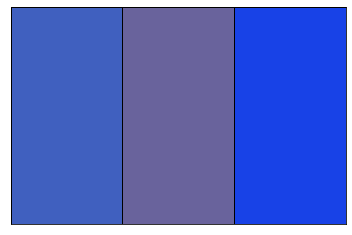

bluest blue


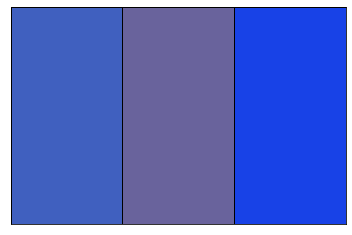

Dark blue.


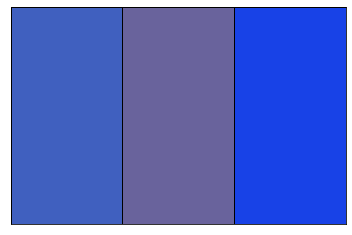

blue


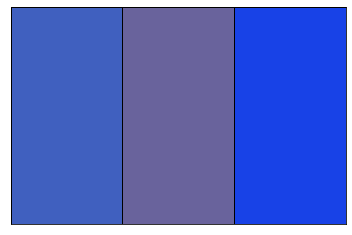

Darkest blue. ~ Yes.


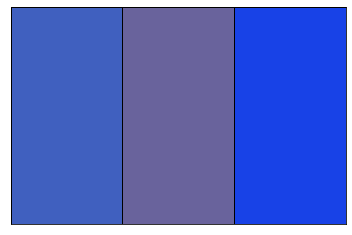

dark blue


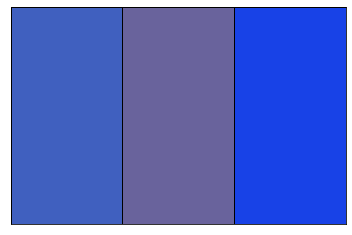

light green


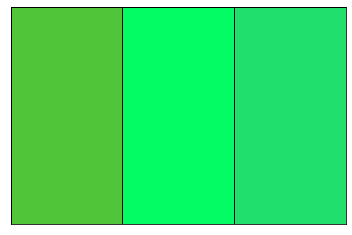

Bright lime green


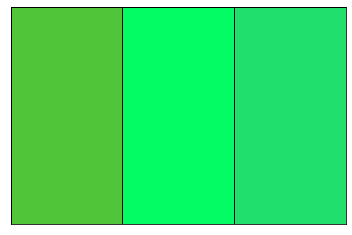

Neon Green


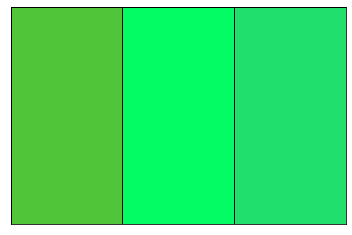

bright green


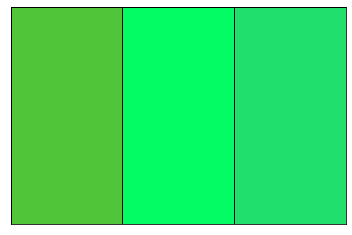

hello ~ are you ready ~ its is the lightes of the other 2 colors


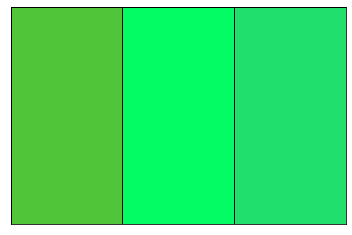

brightest light green


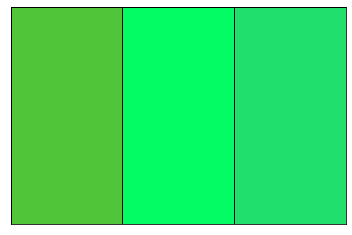

neon green


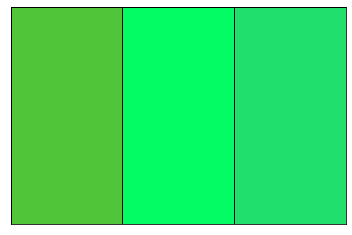

bluish green


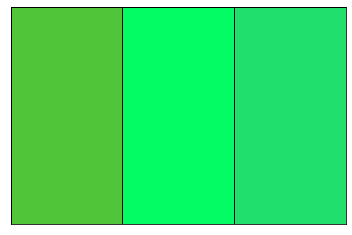

In [400]:
for i in range(len(mistakes)):
    train_data.display_custom_game(mistakes[i].colors, mistakes[i].caption)

deep blue


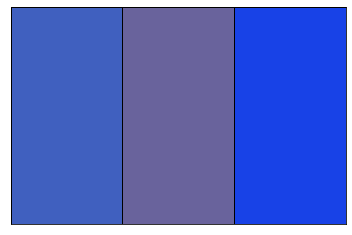

bluest blue


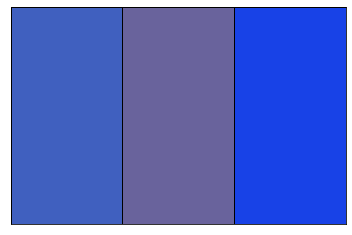

Dark blue.


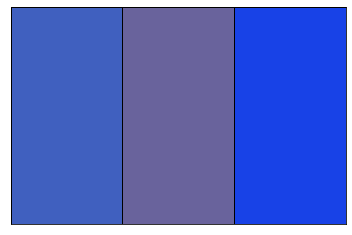

blue


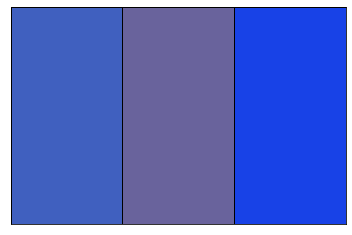

Darkest blue. ~ Yes.


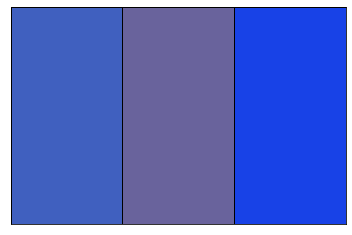

dark blue


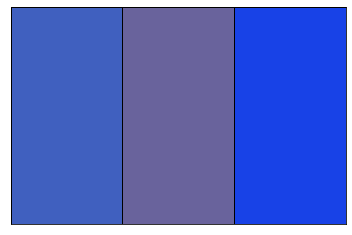

light green


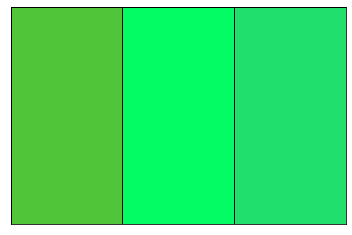

Bright lime green


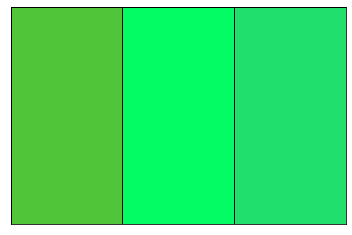

Neon Green


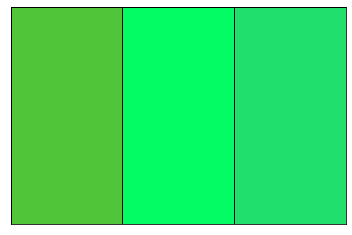

bright green


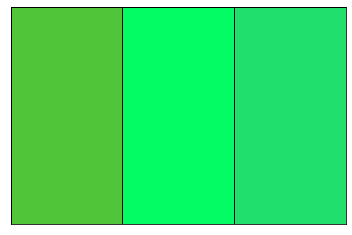

hello ~ are you ready ~ its is the lightes of the other 2 colors


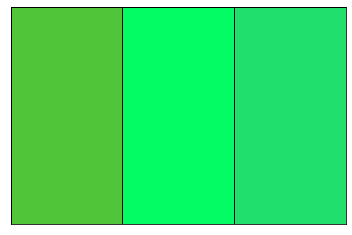

brightest light green


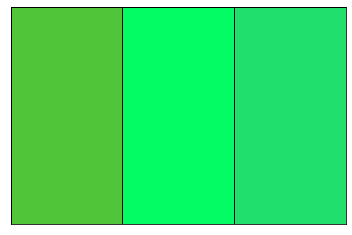

neon green


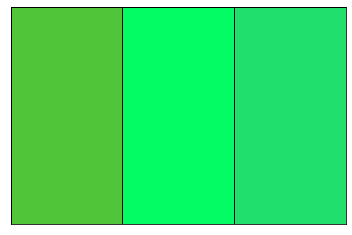

bluish green


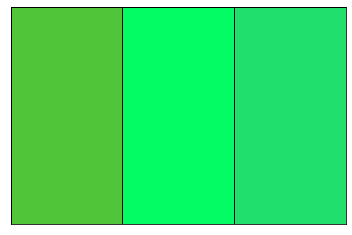

In [408]:
for i in range(len(mistakes)):
    train_data.display_custom_game(mistakes[i].colors, mistakes[i].caption)

In [ ]:
# these colors are slightly different... I have to look into this a bit, but I don't think it's a
# significant source of error.

In [ ]:
## 6.1 Group reference sentences
## 6.2 Prepare descriptive
## 6.3 Prepare ambiguous / misleading
## 6.4 Run NLG metrics


# 7. Prepare for Listener metrics
# 7.1 Flip 